In [ ]:
import pandas as pd
import numpy as np
from IPython.display import clear_output

In [ ]:
from tsai.all import TSDatasets, TSDataLoaders, TSStandardize, Categorize, combine_split_data
from tsai.all import FCN, LSTM, InceptionTime, XceptionTime, XCM, LSTM_FCN, LSTM_FCNPlus
from geoxts.benchmark_models import *
from geoxts.benchmark_data import *

In [ ]:
random_seed(0, use_cuda=True)

In [4]:
#We first create downsample the gamma rays to per feet.
df_log = pd.read_parquet('data/well_logs_data/Colorado_data/Training/logs.parquet', engine='fastparquet')
#df_log = df_log.set_index('wellName')
df_log.loc[df_log['GR'] < -1, 'GR' ] = -1
df_loc = pd.read_parquet('data/well_logs_data/Colorado_data/Training/loc.parquet', engine='fastparquet')
df_loc = df_loc.reset_index()
df_log = df_loc.merge(df_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')
print(df_log.head())

      wellName   Latitude  Longitude  DEPTH        GR
0  512320698.0  48.673353   2.145178  421.0   96.9752
1  512320698.0  48.673353   2.145178  421.5  102.3324
2  512320698.0  48.673353   2.145178  422.0  104.6432
3  512320698.0  48.673353   2.145178  422.5   99.2187
4  512320698.0  48.673353   2.145178  423.0   92.0200


In [5]:
df_tops = pd.read_parquet('data/well_logs_data/Colorado_data/Training/tops.parquet', engine='fastparquet')
df_tops.set_index('well_name', inplace = True)
cols = ['NIOBARA','CODELL', 'FORT_HAYS']
df_tops = df_tops[cols]
df_tops.dropna(inplace = True)
df_tops.head()

,NIOBARA,CODELL,FORT_HAYS
well_name,,,
512320698.0,6398.0,6638.0,6661.0
512320699.0,6407.0,6656.0,6676.0
512320928.0,6520.0,6746.0,6793.0
512320970.0,6544.0,6770.0,6816.0
512320971.0,6510.0,6742.0,6789.0


In [6]:
# Load the training_well array from the file which contains the wells with good signature cluster
well_array = np.load('data/well_logs_data/Colorado_data/Training/training_well_list.npy', allow_pickle=True)

In [8]:
input_variable = ['GR', 'Depth','Latitude','Longitude']
#extract training data
X_train, y_train = extract_dataset_Xy(df_log,df_tops,well_array, input_variable, wsize=201, top_list_bool=1)
X_train.shape, y_train.shape

((4217, 4, 201), (4217,))

In [ ]:
np.unique(y_train)

array([0., 1., 2., 3.])

In [9]:
#validing datastet for the recall calculation
df_valid_log = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/logs_50.parquet', engine='fastparquet')
df_valid_log.loc[df_valid_log['GR'] < -1, 'GR' ] = -1
df_valid_log.loc[df_valid_log['GR'] > 400, 'GR' ] = 400
#df_loc = df_loc.reset_index()
df_valid_loc = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/loc_50.parquet', engine='fastparquet')
df_valid_loc = df_valid_loc.reset_index()
df_valid_log = df_valid_loc.merge(df_valid_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')
df_valid_tops = pd.read_csv('data/well_logs_data/Colorado_data/testdata/tops_50.csv')
df_valid_tops = df_valid_tops.set_index('wellName')
cols = ['NIOBARA','CODELL', 'FORT_HAYS']
df_valid_tops = df_valid_tops[cols]

In [10]:
#create validation dataset 
X_valid, y_valid = extract_dataset_Xy(df_valid_log,df_valid_tops, well_list= [], input_variable = input_variable, wsize=201)
X_valid.shape, y_valid.shape

((796, 4, 201), (796,))

In [11]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
#tensor dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=25, batch_tfms=[TSStandardize(by_var=True)], num_workers=0) 
#dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=25, num_workers=0) 

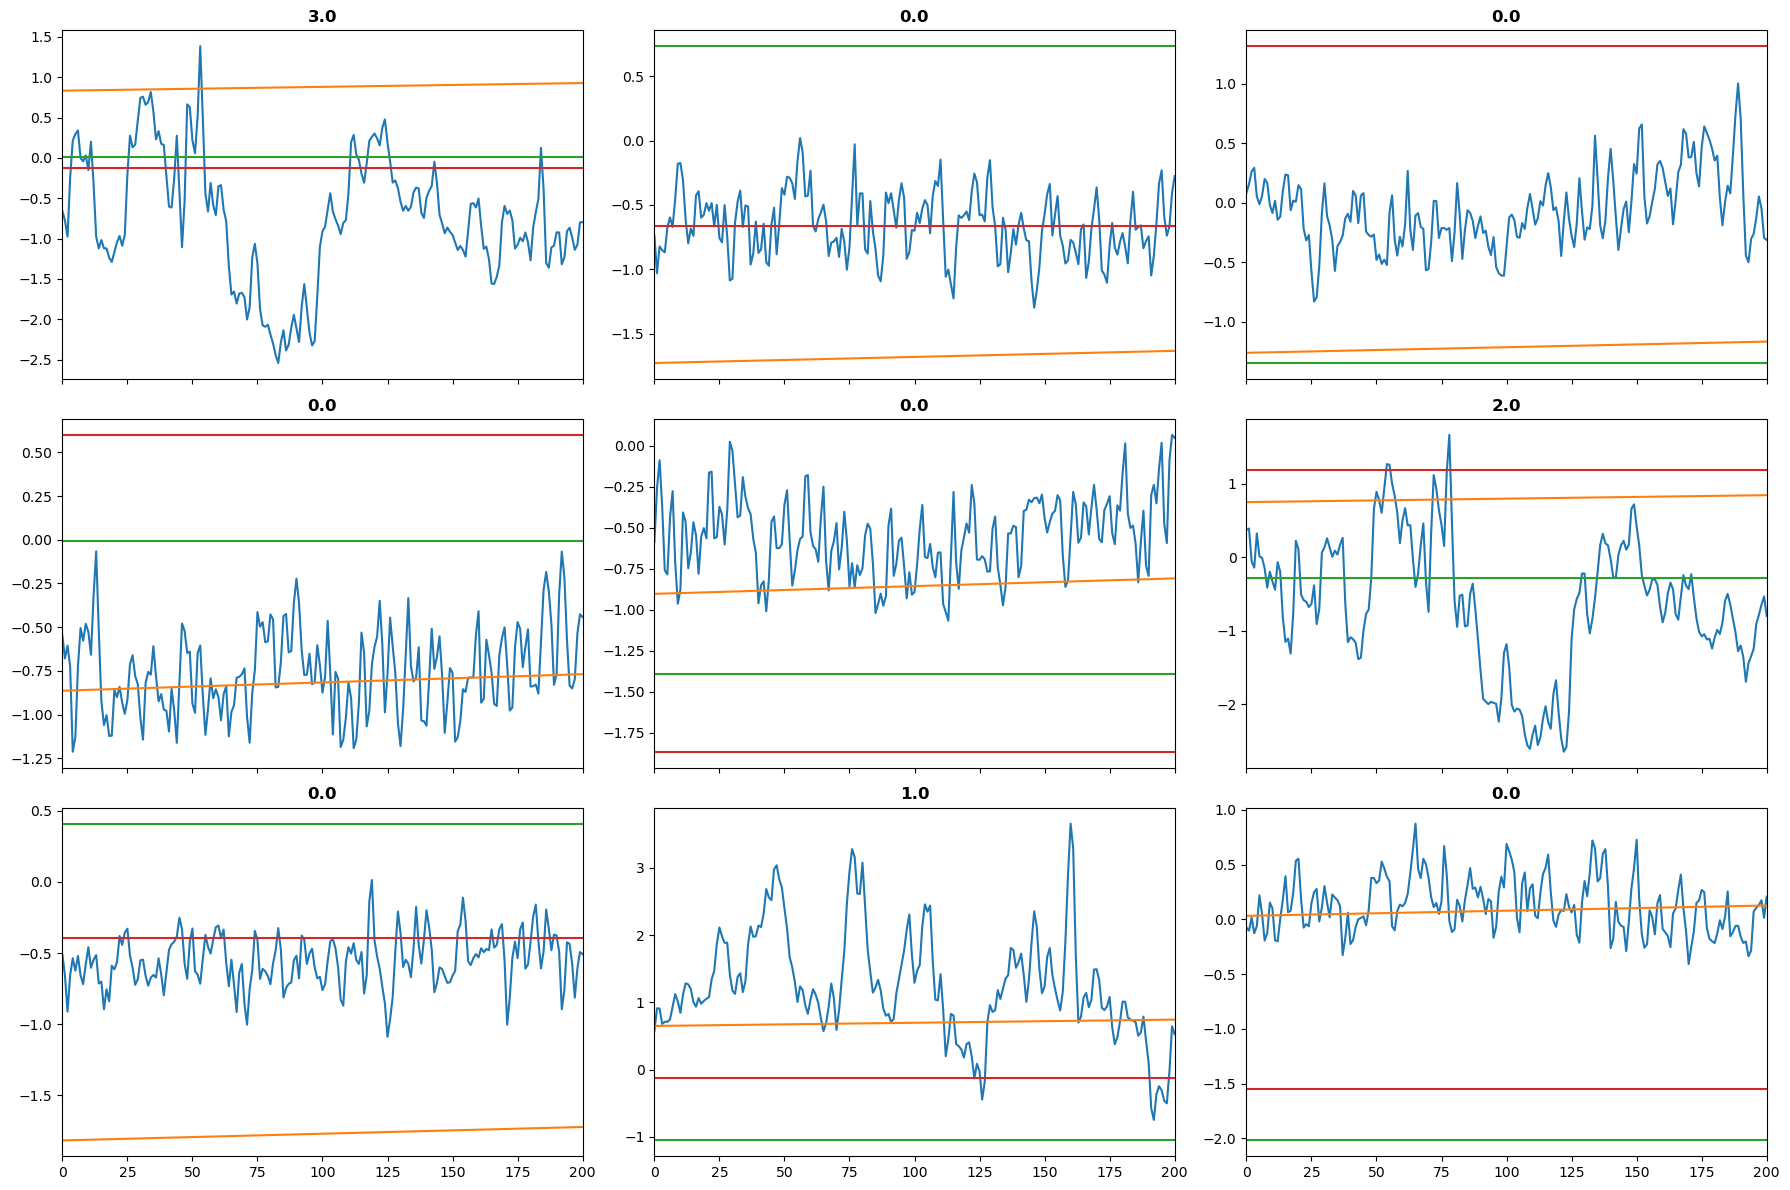

In [12]:
valid_dl = dls.valid
dls.show_batch()

In [13]:
xb, yb = dls.one_batch()
yb

TensorCategory([0, 0, 0, 0, 3, 0, 0, 1, 0, 3, 0, 0, 3, 0, 0, 1, 0, 0, 0, 2, 1,
                0, 3, 1, 0])

In [14]:
#Testing datastet for the recall calculation
df_test_log = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/logs_100.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400
#df_loc = df_loc.reset_index()
df_test_loc = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/loc_100.parquet', engine='fastparquet')
df_test_loc = df_test_loc.reset_index()
df_test_log = df_test_loc.merge(df_test_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')
df_test_tops = pd.read_csv('data/well_logs_data/Colorado_data/testdata/tops_100.csv')
df_test_tops = df_test_tops.set_index('wellName')
cols = ['NIOBARA','CODELL', 'FORT_HAYS']
df_test_tops = df_test_tops[cols]

In [15]:
from fastai.learner import *
from fastai.metrics import accuracy
import time

In [16]:
from fastai.callback.training import *
from fastai.callback.tracker import *
from fastai.test_utils import *
from fastai.callback.schedule import *

In [17]:
model = build_model(LSTM_FCN, dls=dls)
print(model.__class__.__name__)
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
lr_valley = learn.lr_find(show_plot = False)
learn.fit_one_cycle(20, lr_valley, cbs=[SaveModelCallback(monitor='accuracy'), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])
elapsed = time.time() - start
vals = learn.recorder.values[-1]

LSTM_FCN


epoch,train_loss,valid_loss,accuracy,time
0,0.763468,0.702389,0.739950,00:11
1,0.435164,0.470857,0.825377,00:09
2,0.211197,0.119594,0.974874,00:11
3,0.078360,0.057218,0.984925,00:09
4,0.044790,0.058368,0.982412,00:09
5,0.024080,0.079970,0.967337,00:08
6,0.013200,0.086571,0.972362,00:08
7,0.013837,0.113183,0.964824,00:08
8,0.010911,0.094203,0.969849,00:08


Better model found at epoch 0 with accuracy value: 0.7399497628211975.
Better model found at epoch 1 with accuracy value: 0.8253768682479858.
Better model found at epoch 2 with accuracy value: 0.9748743772506714.
Better model found at epoch 3 with accuracy value: 0.9849246144294739.
No improvement since epoch 3: early stopping


In [18]:
#prediction on testing well
wsize = 201
pred_column = ['None','NIOBARA','CODELL', 'FORT_HAYS']
df_tops_pred_100 = Predicted_well_depth(df_test_log,df_test_tops, dls, learn, pred_column, wsize, valid_dl, input_variable)
clear_output()
recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred_100,tolerance = 10)
print(mae, recall)

4.135 0.96


In [19]:
tr = [20, 15, 10, 5]
for tolerance in tr:
    
    recall, mae, df_res = recall_tops(df_test_tops, df_tops_pred_100, tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

tolerance 20, recall 0.99, mae 4.135
tolerance 15, recall 0.9866666666666667, mae 4.135
tolerance 10, recall 0.96, mae 4.135
tolerance 5, recall 0.8866666666666667, mae 4.135


In [20]:
import matplotlib.pyplot as plt

[6585.0, 6847.5, 6871.0] [6585, 6847, 6871]


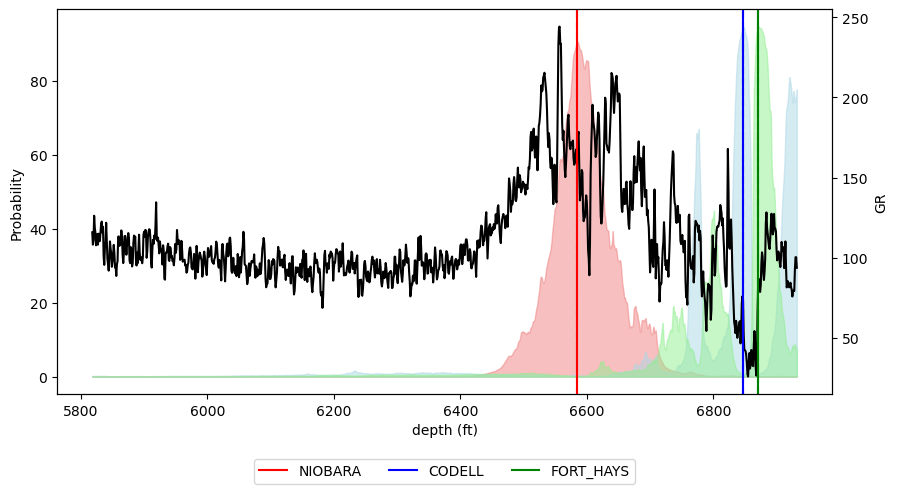

In [21]:
well = df_test_tops.index[1]
td = list(df_test_tops.loc[[well]].values[0])
pred_m = list(df_tops_pred_100.loc[[well]].values[0])
pred_m, df_wm = get_markers(df_test_log, learn, dls, well, pred_column, wsize, valid_dl, input_variable)
#df_wm
top_list = ['NIOBARA','CODELL','FORT_HAYS']
print(td, pred_m)
plot_result_distribution(td, start_depth = 5000, pred_m=pred_m, top_list= top_list,  df_wm=df_wm, Industrial_baseline=False)
